In [1]:
import h5py
import os
import math
from IPython.display import display
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import importlib
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

import datasets
import models
import losses

In [2]:
importlib.reload(datasets)
filepath = 'datasets/nyu_depth/nyu_depth_v2_labeled.mat'
# images, depths = datasets.nyu_depth(filepath, dsize=(224,224))
# x_train, x_test, y_train, y_test = train_test_split(images, depths, test_size=0.2)

# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

train_ds, test_ds, train_size, test_size = datasets.nyu_depth_ds(filepath, 0.2)

In [11]:
# train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_ds = train_ds.batch(5)
print(train_size)
print(test_size)
print(list(train_ds.take(1).as_numpy_iterator())[0][0].shape)



1159
290
(480, 640, 3)


In [7]:
def spatial_augmentation(seed=1234):
    rng = tf.random.Generator.from_seed(seed, alg='philox')
    def augmentor(image, label):
        #flip_lr, flip_ud, crop, 
        seed = rng.make_seeds(2)[0]
        label = tf.expand_dims(label, 2)
        image = tf.image.stateless_random_flip_left_right(image, seed)
        label = tf.image.stateless_random_flip_left_right(label, seed)
#         image = tf.image.stateless_random_flip_up_down(image, seed)
#         label = tf.image.stateless_random_flip_up_down(label, seed)
        
#         if rng.uniform((1,))[0] > 0.5:
#             scale_factor = rng.uniform((1,), minval=0.6, maxval=0.8)[0]
#             w = image.shape[0]*scale_factor
#             h = image.shape[1]*scale_factor
            
        image = tf.image.resize(tf.image.stateless_random_crop(image, (480,480, 3), seed), (image.shape[0], image.shape[1]))
        label = tf.image.resize(tf.image.stateless_random_crop(label, (480,480, 1), seed), (label.shape[0], label.shape[1]))

        image = tf.cast(image, tf.float64)
            
        return image, label[:, :, 0]
    
    return augmentor

def rgb_augmentation(seed=1234):
    rng = tf.random.Generator.from_seed(seed, alg='philox')
    def rgb_augmentor(image, label):
        seed = rng.make_seeds(2)[0]
        image = tf.image.stateless_random_brightness(image, 0.05, seed)
        image = tf.image.stateless_random_hue(image, 0.08, seed)
        image = tf.image.stateless_random_saturation(image, 0.6, 1.6, seed)
        image = tf.image.stateless_random_contrast(image, 0.7, 1.3, seed)
        
        return image, label
        
    return rgb_augmentor

def resize(shape):
    def resizer(image, label):
        label = tf.expand_dims(label, 2)
        image = tf.image.resize(image, shape)
        label = tf.image.resize(label, shape)
        
        return image, label[:, :, 0]
        
    return resizer


# spatial_augmentor = spatial_augmentation()
# rgb_augmentor = rgb_augmentation()
# for i in range(30):
#     image, label = next(iter(train_ds))
#     image, label = rgb_augmentor(image, label)
#     image, label = spatial_augmentor(image, label)
#     fig = plt.figure()
#     plt.subplot(1,2,1)
#     plt.title('Original image')
#     plt.imshow(image)
    
#     plt.subplot(1,2,2)
#     plt.title('Augmented image')
#     plt.imshow(label)


In [20]:
def experiment(filename, model, loss, optimizer, batch_size, epochs, augment_rgb=True, augment_spatial=True):
    metrics = tf.keras.metrics.CosineSimilarity()
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    train = train_ds
    test = test_ds
    if augment_rgb:
        train = train.map(rgb_augmentation())
    if augment_spatial:
        train = train.map(spatial_augmentation())

    train = train_ds.map(resize((224, 224)))
    test = test_ds.map(resize((224, 224)))
    
    train = train.batch(batch_size)
    test = test.batch(batch_size)
    model.fit(train,
        epochs=epochs,
        steps_per_epoch = math.floor(train_size/batch_size),
        verbose = 1,
        validation_data = test)
    model.save(filename, include_optimizer=False)

In [5]:
def evaluate_model(model, count):
    ds = train_ds.take(count).map(resize((224, 224)))
    f, axarr = plt.subplots(count,3)
    f.set_figheight(5*count)
    f.set_figwidth(15)
    i = 0
    for image, label in ds.as_numpy_iterator():
        img = (image * 255).astype(np.uint8)
        
        out = model.predict(np.expand_dims(image, axis=0))

        axarr[i, 0].imshow(image)
        axarr[i, 1].imshow(label)
        axarr[i, 2].imshow(out[0, :, :, 0])
        i = i + 1
    plt.show()
    

# Experiments

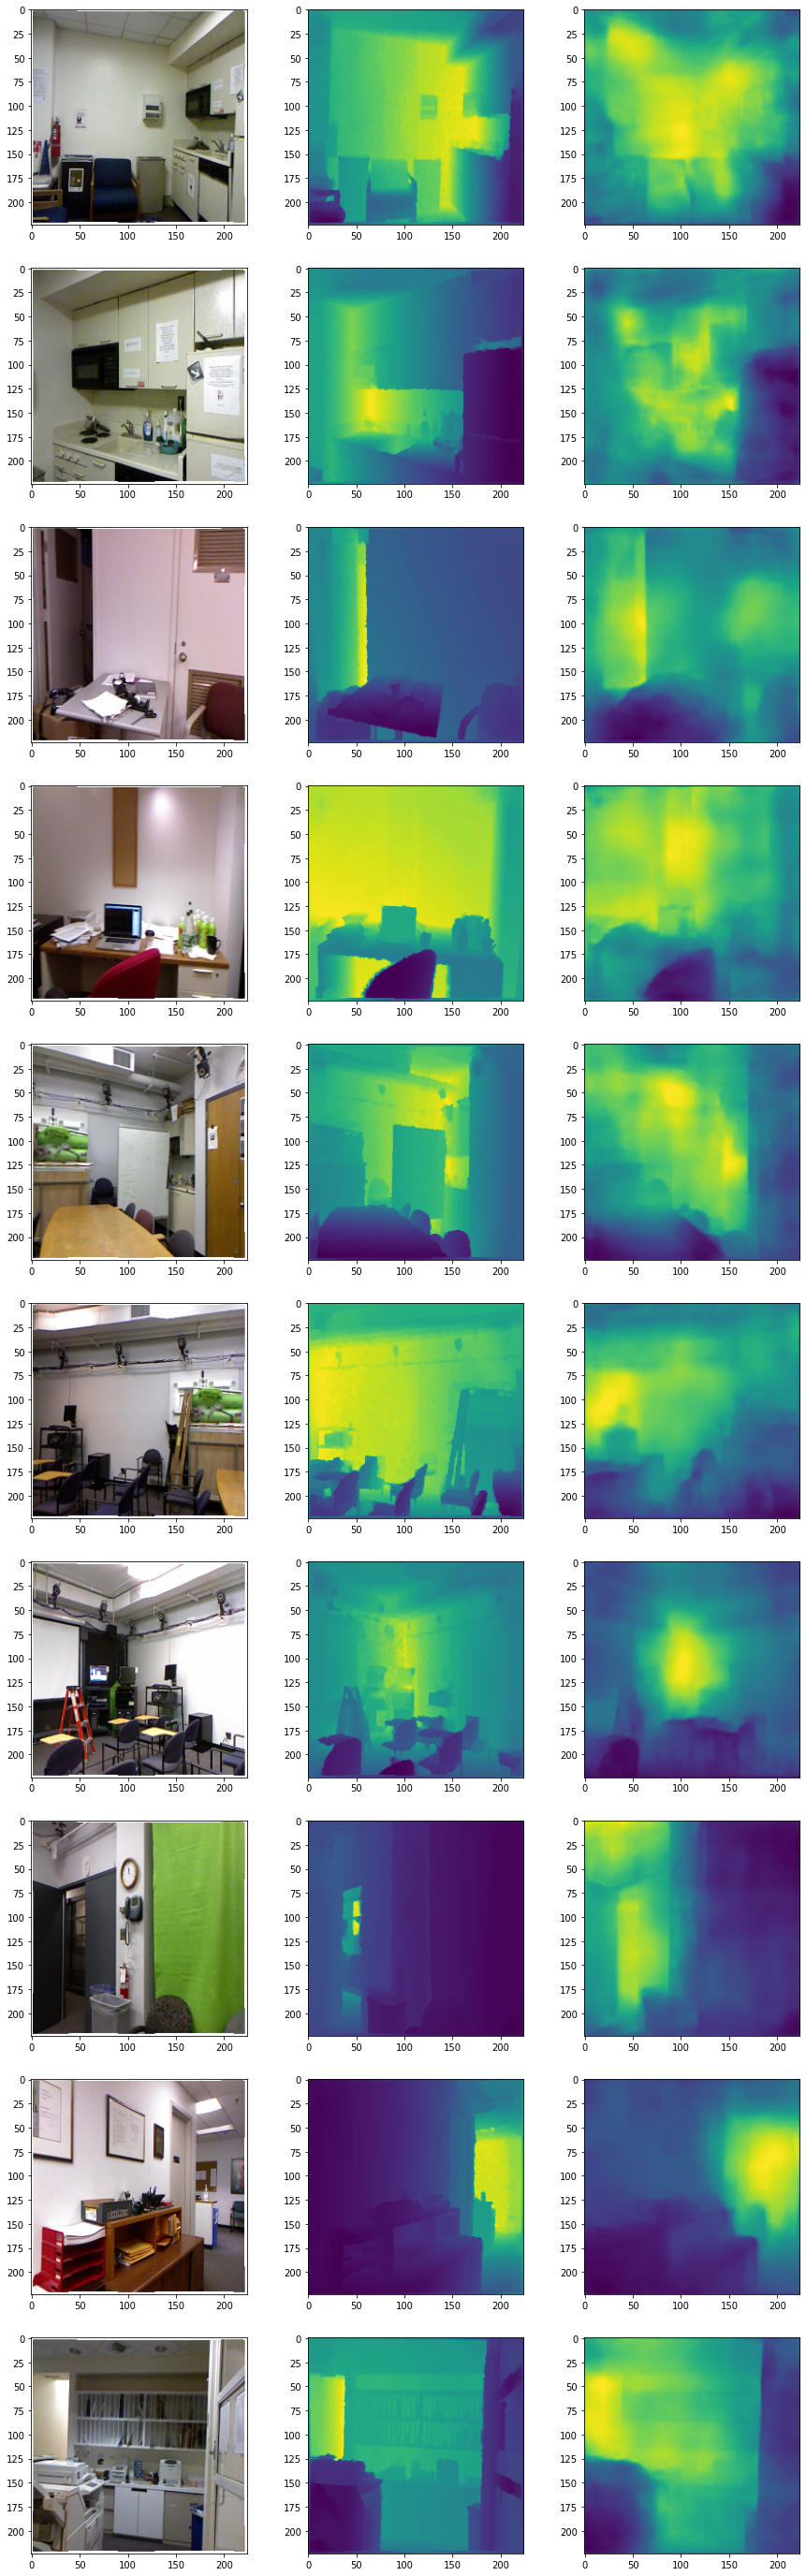

In [8]:
# model: mobilenet unet
# iters: 220, bs: 5, data augmentation: none
# loss: l1 + 0.5*ssim + 0.5*edge
# optimizer: SGD with lr 0.01 and momentum 0.9
m = tf.keras.models.load_model("saved_models/mobilenet_unet_1.h5")
evaluate_model(m, 10)

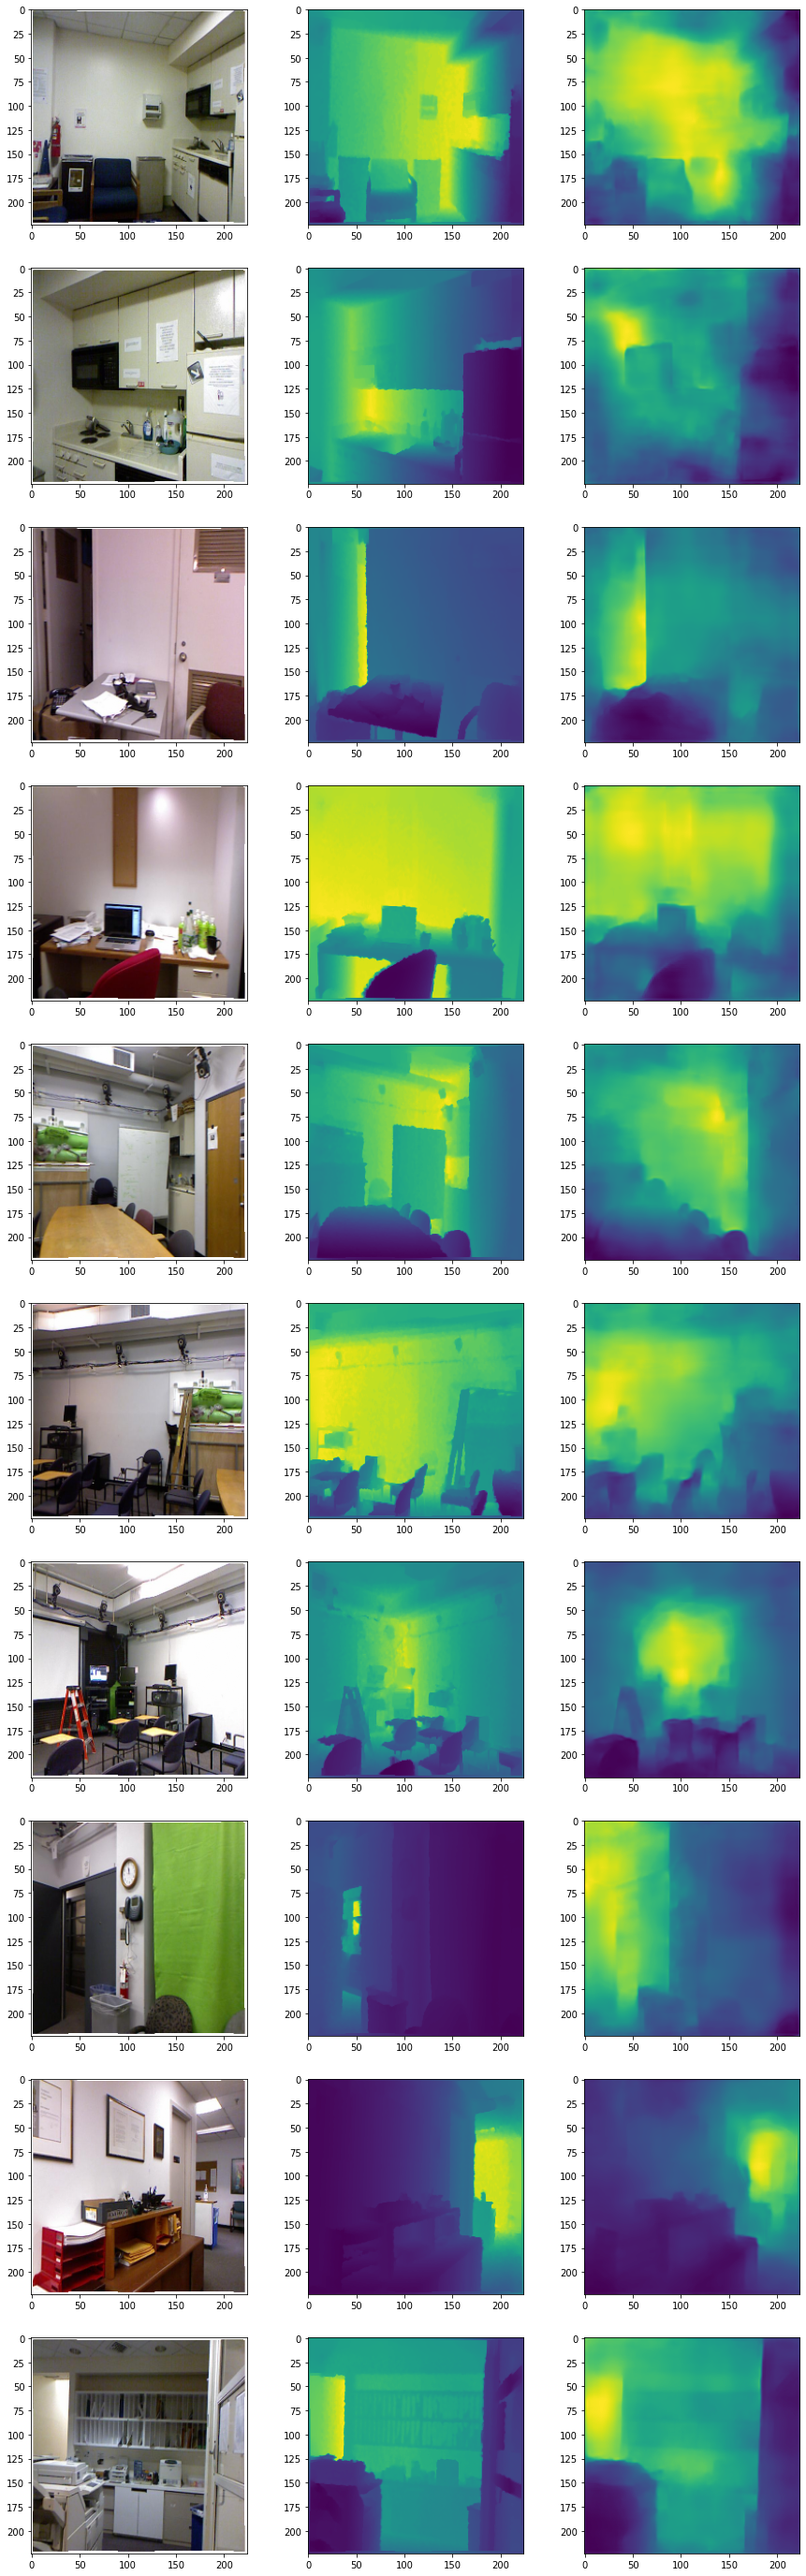

In [23]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: l1 + 0.5*ssim + 0.5*edge
# optimizer: SGD with lr 0.01 and momentum 0.9
m = tf.keras.models.load_model("saved_models/mobilenet_unet_2.h5")
evaluate_model(m, 10)

231/231 [==============================] - 294s 1s/step - loss: 0.2474 - cosine_similarity: 0.9593 - val_loss: 0.1598 - val_cosine_similarity: 0.9712


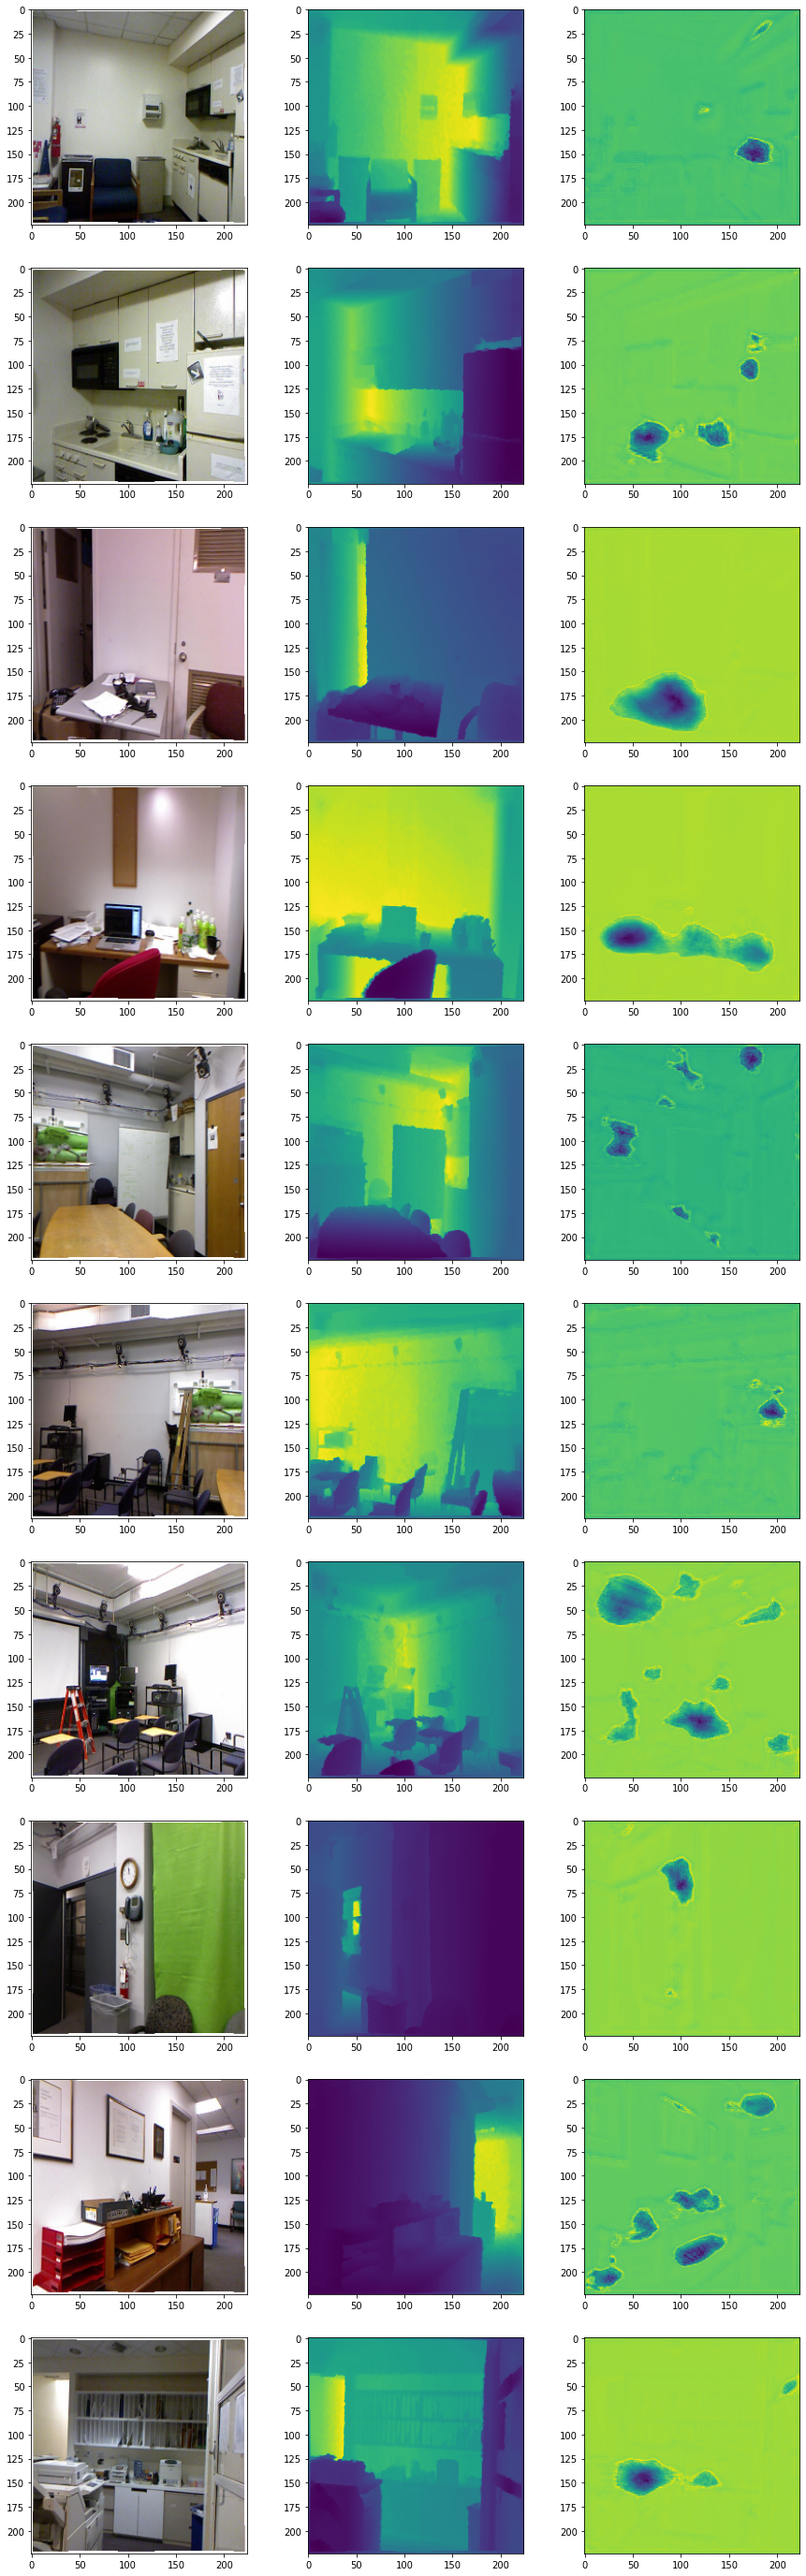

In [22]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 0.3 * l1 + 1.0 * ssim + 1.0 * edge
# optimizer: SGD with lr 0.01 and momentum 0.9
importlib.reload(models)
importlib.reload(losses)
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=0.3, ssim_weight=1.0, edge_weight=1.0)
optimizer = keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9)
experiment("saved_models/mobilenet_unet_3.h5", model, loss, optimizer, 5, 30)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_3.h5")
evaluate_model(m, 10)

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 1.0 * l1 + 0.5 * ssim + 0.5 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=1.0, ssim_weight=0.5, edge_weight=0.5)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_4.h5", model, loss, optimizer, 5, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_4.h5")
evaluate_model(m, 10)

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 0.3 * l1 + 1.0 * ssim + 1.0 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=0.3, ssim_weight=1.0, edge_weight=1.0)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_5.h5", model, loss, optimizer, 5, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_5.h5")
evaluate_model(m, 10)

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 1.0 * l1 + 0 * ssim + 0 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=1.0, ssim_weight=0, edge_weight=0)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_6.h5", model, loss, optimizer, 5, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_6.h5")
evaluate_model(m, 10)

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 5, data augmentation: none
# loss: 1.0 * l1 + 1.0 * ssim + 1.0 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=1.0, ssim_weight=1.0, edge_weight=1.0)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_7.h5", model, loss, optimizer, 5, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_7.h5")
evaluate_model(m, 10)

In [ ]:
# model: mobilenet unet
# iters: 450, bs: 8, data augmentation: none
# loss: 1.0 * l1 + 0.5 * ssim + 0.5 * edge
# optimizer: Adam lr rate 0.01
model = models.mobilenet_unet(224, 224, 3)
loss = losses.l1_ssim_edge(l1_weight=1.0, ssim_weight=0.5, edge_weight=0.5)
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
experiment("saved_models/mobilenet_unet_8.h5", model, loss, optimizer, 8, 450)
m = tf.keras.models.load_model("saved_models/mobilenet_unet_8.h5")
evaluate_model(m, 10)